In [ ]:
import os

# Define directory structure
dirs = [
    "data",
    "models",
    "optim",
    "loss",
    "utils",
    "experiments"
]

# Define empty files to create
files = [
    "train.py",
    "config.py",
    "requirements.txt",
    "README.md",
    "data/dataloader.py",
    "models/layers.py",
    "models/neuralnet.py",
    "optim/optimizers.py",
    "loss/loss_functions.py",
    "utils/metrics.py",
    "utils/wandb_utils.py",
    "experiments/sweep_config.yaml"
]

# Create directories
for dir_path in dirs:
    os.makedirs(dir_path, exist_ok=True)

# Create empty files
for file_path in files:
    with open(file_path, 'w') as f:
        f.write("# " + os.path.basename(file_path))

print("✅ Project structure created successfully.")


In [2]:
from keras.datasets import fashion_mnist


2025-05-15 10:24:20.544473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


conda command
conda create -n dl_cpu_env python=3.10 pytorch torchvision torchaudio cpuonly numpy pandas -c pytorch -c conda-forge


In [ ]:
import torch
w=torch.randn((30,3))
x=torch.randn((3,))
b=torch.randn((30,))


In [ ]:
x.shape,w.shape,b.shape

In [ ]:
torch.equal(w@x+b,x@w.T+b)

In [ ]:
import torch

# suppose
# A has shape (B, k2)
# B has shape (B, k1)
B = 5
k1 = 3
k2 = 4
A = torch.randn(B, k2)
B = torch.randn(B, k1)

# step 1: make them broadcastable to (B, k2, k1)
#   A.unsqueeze(2) has shape (B, k2, 1)
#   B.unsqueeze(1) has shape (B, 1, k1)
outer = A.unsqueeze(2) * B.unsqueeze(1)
# outer.shape == (B, k2, k1)

# step 2: sum over the batch dimension → (k2, k1), then add the leading dim
final = outer.sum(dim=0, keepdim=True)
# final.shape == (1, k2, k1)


In [ ]:
final

In [ ]:
A.T

In [ ]:
A.T @ B

In [ ]:
A.unsqueeze(2)

In [ ]:
B.unsqueeze(1)

In [ ]:
final

In [ ]:
A

In [ ]:
B[0,:]

In [ ]:
A[0,:].T

In [ ]:
A[0,:].T.unsqueeze(0).shape

In [ ]:
A[0,:].T@B[0,:]

In [ ]:
A


In [ ]:
A[0,:].T.unsqueeze(1)

In [ ]:
B[0,:].unsqueeze(0)

In [ ]:
B

In [ ]:
A[0,:].T.unsqueeze(1)@B[0,:].unsqueeze(0)

In [ ]:
outer

In [ ]:
final

In [ ]:
import torch
# B = 5
# k1 = 3
# k2 = 4
# A = torch.randn(B, k2)
# B = torch.randn(B, k1)

# direct outer‐product per batch
outer = torch.einsum('bi,bj->bij', A, B)
# outer.shape == (B, k2, k1)

# sum over batch
final = outer.sum(0, keepdim=True)
# final.shape == (1, k2, k1)


In [ ]:
k=range(5,0,-1)
print(type(k))

In [ ]:
for i in range(5,-1,-1):
    print(i)

In [3]:
import torch
import sys
import os
import torch.nn as nn
# Adjust path so you can import your models
# sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.backprop import Backpropagation

In [ ]:
class TestBackpropagation:
    def __init__(self):
        torch.manual_seed(42)
        self.bp = Backpropagation()
        self.batch_size = 5
        self.curr_neurons = 3
        self.prev_neurons = 4
        
        self.predictions = torch.softmax(torch.randn(self.batch_size, self.curr_neurons), dim=1)
        indices = torch.randint(0, self.curr_neurons, (self.batch_size,))
        self.targets = torch.zeros_like(self.predictions)
        self.targets[torch.arange(self.batch_size), indices] = 1
        
        self.weight_matrix = torch.randn(self.curr_neurons, self.prev_neurons)
        self.gradient_pre_activation = torch.randn(self.batch_size, self.curr_neurons)
        self.activations_prev = torch.randn(self.batch_size, self.prev_neurons)
        self.activation = torch.sigmoid(torch.randn(self.batch_size, self.curr_neurons))
    
    def test_cross_entropy_output_grad(self):
        expected = -(self.targets - self.predictions)/ self.batch_size
        result = self.bp.cross_entropy_output_grad(self.predictions, self.targets)
        print("cross_entropy_output_grad:", torch.allclose(result, expected, atol=1e-6))
    
    def test_dloss_dactivations_prev(self):
        expected = self.gradient_pre_activation @ self.weight_matrix
        result = self.bp.dloss_dactivations_prev(self.weight_matrix, self.gradient_pre_activation)
        print("dloss_dactivations_prev:", torch.allclose(result, expected, atol=1e-6))
    
    def test_dloss_dweights(self):
        expected = self.gradient_pre_activation.T @ self.activations_prev
        result = self.bp.dloss_dweights(self.activations_prev, self.gradient_pre_activation)
        print("dloss_dweights:", torch.allclose(result, expected, atol=1e-6))
    
    def test_dloss_dbias(self):
        expected = self.gradient_pre_activation.sum(dim=0)
        result = self.bp.dloss_dbias(self.gradient_pre_activation)
        print("dloss_dbias:", torch.allclose(result, expected, atol=1e-6))
    
    def test_dactivation_dpreactivation_sigmoid(self):
        expected = self.activation * (1 - self.activation)
        result = self.bp.dactivation_dpreactivation(self.activation, 'sigmoid')
        print("dactivation_dpreactivation (sigmoid):", torch.allclose(result, expected, atol=1e-6))
    
    def test_dactivation_dpreactivation_tanh(self):
        act = torch.tanh(torch.randn(self.batch_size, self.curr_neurons))
        expected = 1 - act.pow(2)
        result = self.bp.dactivation_dpreactivation(act, 'tanh')
        print("dactivation_dpreactivation (tanh):", torch.allclose(result, expected, atol=1e-6))
    
    def test_dactivation_dpreactivation_relu(self):
        act = torch.randn(self.batch_size, self.curr_neurons)
        expected = (act > 0).to(act.dtype)
        result = self.bp.dactivation_dpreactivation(act, 'relu')
        print("dactivation_dpreactivation (relu):", torch.equal(result, expected))
    
    def test_gradients_model_single_layer(self):
        class DummyLayer:
            def __init__(self, weight, bias, input):
                self.weight = weight
                self.bias = bias
                self.input = input
        
        dummy_weight = torch.randn(self.curr_neurons, self.prev_neurons, requires_grad=True)
        dummy_bias = torch.randn(self.curr_neurons, requires_grad=True)
        dummy_input = torch.randn(self.batch_size, self.prev_neurons)
        layer = DummyLayer(weight=dummy_weight, bias=dummy_bias, input=dummy_input)
        
        predictions = dummy_input @ dummy_weight.t() + dummy_bias 
        predictions = torch.softmax(predictions, dim=1)
        indices = torch.randint(0, self.curr_neurons, (self.batch_size,))
        targets = torch.zeros_like(predictions)
        targets[torch.arange(self.batch_size), indices] = 1
        
        grad_output = self.bp.cross_entropy_output_grad(predictions, targets)
        layer.weight.grad = self.bp.dloss_dweights(dummy_input, grad_output)
        layer.bias.grad = self.bp.dloss_dbias(grad_output)
        
        dummy_weight2 = dummy_weight.clone().detach().requires_grad_(True)
        dummy_bias2 = dummy_bias.clone().detach().requires_grad_(True)
        predictions2 = dummy_input @ dummy_weight2.t() + dummy_bias2
        predictions2 = torch.softmax(predictions2, dim=1)
        log_preds = torch.log(predictions2 + 1e-9)
        loss = -(targets * log_preds).sum()/self.batch_size
        print(loss)
        predictions2 = torch.clamp(predictions2, min=1e-7, max=1 - 1e-7)
        loss1 = -torch.sum(targets * torch.log(predictions2), dim=1).mean()
        loss2 = 
        #loss=loss.sum(dim=0)/self.batch_size
        print(loss1)
        loss.backward()
        
        print("gradients_model: weight grad:", torch.allclose(layer.weight.grad, dummy_weight2.grad, atol=1e-6))
        print("gradients_model: bias grad:", torch.allclose(layer.bias.grad, dummy_bias2.grad, atol=1e-6))
        print("pytorch: weight grad:", dummy_weight2.grad)
        print("pytorch: bias grad:", dummy_bias2.grad)
        print("custom: weight grad:", layer.weight.grad)
        print("custom: bias grad:", layer.bias.grad)

    def test_gradients_model_multi_layer(self):
        # Create a 2-layer model (input_size=4, hidden_size=5, output_size=3)
        input_size = 4
        hidden_size = 5
        output_size = 3
        batch_size = 5
        
        class DummyLayer:
            def __init__(self, weight, bias):
                self.weight = weight
                self.bias = bias
                self.input = None  # Previous layer's post-activation output
                self.pre_activation = None  # Current layer's pre-activation

            def forward(self, x):
                self.input = x.detach()  # Store input (a_{l-1})
                self.pre_activation = x @ self.weight.T + self.bias  # Store z_l
                return self.pre_activation

        # Initialize custom model
        W1 = torch.randn(hidden_size, input_size, requires_grad=True)
        b1 = torch.randn(hidden_size, requires_grad=True)
        W2 = torch.randn(output_size, hidden_size, requires_grad=True)
        b2 = torch.randn(output_size, requires_grad=True)
        
        layer1 = DummyLayer(W1, b1)
        layer2 = DummyLayer(W2, b2)
        custom_model = [layer1, layer2]
        
        # Forward pass with custom model
        x = torch.randn(batch_size, input_size)
        z1 = layer1.forward(x)
        a1 = torch.relu(z1)
        z2 = layer2.forward(a1)
        predictions = torch.softmax(z2, dim=1)
        
        # Create targets
        targets = torch.zeros_like(predictions)
        targets[torch.arange(batch_size), torch.randint(0, output_size, (batch_size,))] = 1
        
        # Compute custom gradients
        bp = Backpropagation()
        bp.gradients_model(custom_model, predictions, targets, 'relu')
        
        # Compute PyTorch gradients
        torch_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        with torch.no_grad():
            torch_model[0].weight.copy_(W1)
            torch_model[0].bias.copy_(b1)
            
            torch_model[2].weight.copy_(W2)
            torch_model[2].bias.copy_(b2)
        
        torch_model.zero_grad()


        
        torch_pred = torch_model(x)
        loss = nn.CrossEntropyLoss()(torch_pred, targets.argmax(dim=1))
        loss.backward()
        
        # Compare gradients
        print(
                        "Input layer weight gradients:",torch.allclose(custom_model[0].weight.grad, torch_model[0].weight.grad, atol=1e-6))
        print(
                        "Input layer bias gradients:",torch.allclose(custom_model[0].bias.grad, torch_model[0].bias.grad, atol=1e-6))
        print("Output layer weight gradients:",torch.allclose(custom_model[1].weight.grad, torch_model[2].weight.grad, atol=1e-6)
                        )
        print("Output layer bias gradients:",torch.allclose(custom_model[1].bias.grad, torch_model[2].bias.grad, atol=1e-6)
                        )
        print("Custom gradients:")
        print("Input layer weight grad:", custom_model[0].weight.grad)
        print("Input layer bias grad:", custom_model[0].bias.grad)
        print("Output layer weight grad:", custom_model[1].weight.grad)
        print("Output layer bias grad:", custom_model[1].bias.grad)
        print("PyTorch gradients:")
        print("Input layer weight grad:", torch_model[0].weight.grad)
        print("Input layer bias grad:", torch_model[0].bias.grad)
        print("Output layer weight grad:", torch_model[2].weight.grad)
        print("Output layer bias grad:", torch_model[2].bias.grad)
        
        

In [5]:
tester = TestBackpropagation()

In [6]:
tester.test_cross_entropy_output_grad()
tester.test_dloss_dactivations_prev()
tester.test_dloss_dweights()
tester.test_dloss_dbias()
tester.test_dactivation_dpreactivation_sigmoid()
tester.test_dactivation_dpreactivation_tanh()
tester.test_dactivation_dpreactivation_relu()

cross_entropy_output_grad: True
dloss_dactivations_prev: True
dloss_dweights: True
dloss_dbias: True
dactivation_dpreactivation (sigmoid): True
dactivation_dpreactivation (tanh): True
dactivation_dpreactivation (relu): True


In [7]:
tester.test_gradients_model_single_layer()

tensor(2.5210, grad_fn=<DivBackward0>)
tensor(2.5210, grad_fn=<NegBackward0>)
gradients_model: weight grad: True
gradients_model: bias grad: True
pytorch: weight grad: tensor([[ 0.2978,  0.3779, -0.0801, -0.4740],
        [ 0.0027, -0.2751,  0.1070,  0.7012],
        [-0.3005, -0.1028, -0.0270, -0.2272]])
pytorch: bias grad: tensor([-0.2054,  0.3958, -0.1903])
custom: weight grad: tensor([[ 0.2978,  0.3779, -0.0801, -0.4740],
        [ 0.0027, -0.2751,  0.1070,  0.7012],
        [-0.3005, -0.1028, -0.0270, -0.2272]], grad_fn=<MmBackward0>)
custom: bias grad: tensor([-0.2054,  0.3958, -0.1903], grad_fn=<SumBackward1>)


In [22]:
tester.test_gradients_model_multi_layer()

Input layer weight gradients: True
Input layer bias gradients: True
Output layer weight gradients: True
Output layer bias gradients: True
Custom gradients:
Input layer weight grad: tensor([[-0.1258, -0.0947,  0.0406, -0.0294],
        [ 0.0321,  0.0304,  0.0228,  0.0113],
        [ 0.0314, -0.0270, -0.0026, -0.0101],
        [-0.4770, -0.4511, -0.3381, -0.1679],
        [ 0.1588,  0.1597,  0.0762,  0.0669]], grad_fn=<MmBackward0>)
Input layer bias grad: tensor([-0.0627, -0.0229, -0.0280,  0.3399, -0.0931], grad_fn=<SumBackward1>)
Output layer weight grad: tensor([[ 0.0559, -0.0167,  0.2875, -0.2814, -0.5276],
        [ 0.0347,  0.0023, -0.0508,  0.0393,  0.3195],
        [-0.0906,  0.0144, -0.2368,  0.2420,  0.2081]], grad_fn=<MmBackward0>)
Output layer bias grad: tensor([-0.1377,  0.0982,  0.0395], grad_fn=<SumBackward1>)
PyTorch gradients:
Input layer weight grad: tensor([[-0.1258, -0.0947,  0.0406, -0.0294],
        [ 0.0321,  0.0304,  0.0228,  0.0113],
        [ 0.0314, -0.0270, -0

In [2]:
torch.manual_seed(42)
bp = Backpropagation()
batch_size = 5
curr_neurons = 3
prev_neurons = 4




In [3]:
dummy_weight = torch.randn(curr_neurons, prev_neurons, requires_grad=True)
dummy_bias = torch.randn(curr_neurons, requires_grad=True)

In [4]:
dummy_input = torch.randn(batch_size, prev_neurons)

In [5]:
predictions=torch.softmax(dummy_input @ dummy_weight.t() + dummy_bias,dim=1 )
#predictions = torch.softmax(torch.randn(batch_size, curr_neurons), dim=1)
indices = torch.randint(0, curr_neurons, (batch_size,))
targets = torch.zeros_like(predictions)
targets[torch.arange(batch_size), indices] = 1

In [ ]:
predictions

In [ ]:
targets

In [ ]:
torch.log(predictions+1e-9)

In [ ]:
-(targets * torch.log(predictions + 1e-9))#.sum(dim=1)

In [6]:
tr=-(targets * torch.log(predictions + 1e-9)).sum(dim=0).sum(dim=0)/batch_size

In [10]:
tr.backward()

In [11]:
dummy_weight.grad 

tensor([[-0.5237,  0.1172, -0.2873,  0.1701],
        [ 0.4422, -0.3693,  0.7290, -0.2545],
        [ 0.0815,  0.2521, -0.4417,  0.0844]])

In [12]:
dummy_bias.grad

tensor([ 0.4904, -0.4012, -0.0892])

In [7]:
gradient_loss_pre_activation_current_layer =bp.cross_entropy_output_grad(predictions, targets)/batch_size
custom_weight_grad = bp.dloss_dweights(dummy_input, gradient_loss_pre_activation_current_layer)
custom_bias_grad = bp.dloss_dbias(gradient_loss_pre_activation_current_layer)

In [8]:
custom_weight_grad

tensor([[-0.5237,  0.1172, -0.2873,  0.1701],
        [ 0.4422, -0.3693,  0.7290, -0.2545],
        [ 0.0815,  0.2521, -0.4417,  0.0844]], grad_fn=<MmBackward0>)

In [9]:
custom_bias_grad

tensor([ 0.4904, -0.4012, -0.0892], grad_fn=<SumBackward1>)

In [12]:
A=torch.randn((3,4))
A

tensor([[-0.2019,  1.5077,  0.3483,  0.3551],
        [ 0.8158, -0.3620,  0.0705,  0.6056],
        [ 0.2442,  0.3988,  1.7937,  0.4370]])

In [13]:
B=torch.randn((3,4))
B

tensor([[-0.1996,  0.1070, -2.6345, -0.1302],
        [-0.2054,  0.3407, -0.0152,  0.1570],
        [-0.1151, -0.2015, -0.1506, -0.1012]])

In [14]:
A*B

tensor([[ 0.0403,  0.1613, -0.9175, -0.0462],
        [-0.1675, -0.1233, -0.0011,  0.0951],
        [-0.0281, -0.0803, -0.2702, -0.0442]])

In [18]:
A[0,0]*B[0,0]

tensor(0.0403)

In [14]:
t=torch.randn((3,4))
t.grad=torch.randn((3,4))

In [15]:
t.grad

tensor([[ 0.2357, -0.2918,  0.6404, -0.1239],
        [ 0.1319,  0.9267, -1.2518, -1.3380],
        [-0.1074, -0.6182,  1.9594, -1.7176]])

In [23]:
from abc import ABC, abstractmethod

abc.ABC

In [1]:
import torch
from data.dataloader import MNISTDataLoader
dataset=MNISTDataLoader(dataset="fashion_mnist",dtype=torch.float32,batch_size=4,device="cpu",normalize=True)

2025-05-16 12:10:32.296103: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sys
import os
sys.path.insert(0, "/workspaces/Learn_deep_learning_1/models")
from models.model_layers import DenseLayer
import torch
from models.neuralnet import DenseNet_classifier
from models.backprop import Backpropagation
from loss.loss_functions import CrossEntropyLoss


In [3]:
model=DenseNet_classifier(model_config=[784,64,64,64,10],dtype=torch.float32,device="cpu",weight_init="xavier",activation_hidden_layers="relu",  loss_function="cross_entropy")

In [4]:
from optim.optimizers_weight_decay import SGD, Adam, RMSprop, Nadam, Nesterov, Nadam

In [5]:
opt=Nadam(layers=model.model,lr=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0)

In [8]:
lf=CrossEntropyLoss(dtype=torch.float32,device="cpu")

In [26]:
torch.randint(0, 50000, (32,))

tensor([26322,  4646, 46844, 36747, 43762, 14756, 39513, 19270, 14964, 35724,
        23814,  8413, 27237, 42575, 15469, 48446, 41892, 29131, 29956, 33413,
        10800, 23700, 43948, 39887, 31538,  1321, 43695, 38173, 25552,  2611,
        17791, 37728])

In [6]:
img,target=dataset.get_batch()

In [ ]:
predictions=model.forward(img) 
loss=lf.forward(predictions,target)


In [ ]:
#manual forward pass and backward pass 3 times
for img, target in dataset.get_batch():
    forward_pass = model.forward(img)
    loss = lf.forward(forward_pass, target)
    

tensor([[0.1302, 0.0616, 0.1058, 0.1209, 0.1457, 0.1089, 0.0666, 0.0945, 0.0487,
         0.1171],
        [0.1375, 0.0969, 0.0854, 0.1263, 0.1592, 0.0841, 0.0794, 0.0832, 0.0327,
         0.1154],
        [0.1505, 0.0515, 0.0903, 0.0969, 0.1646, 0.1020, 0.0912, 0.0885, 0.0325,
         0.1321],
        [0.1200, 0.0859, 0.0957, 0.1021, 0.1525, 0.0954, 0.0777, 0.0979, 0.0588,
         0.1140]])

In [ ]:
x=imgs
model.model[0].forward(x)
# for layer_number in range(len(model.model)-1):
#     x = model.model[layer_number].forward(x)
#     x = model.activation.apply(x,model.activation_hidden_layers)
#     print(x)
#     break
# x = model.model[-1].forward(x)
# x = model.activation.apply(x,'softmax')

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, na

In [26]:
torch.zeros((4,10))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [23]:
model.model[0].bias

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [19]:
x

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [30]:
from models.layers import DenseLayer
z=DenseLayer(784,32,weight_init="xavier",dtype=torch.float32,device="cpu")

tensor([[-1.0732e+00, -5.8433e-01,  7.7931e-01,  6.1182e-01,  8.5824e-02,
         -8.2159e-01, -1.9875e-01, -1.3756e+00,  4.5408e-01,  1.2193e+00,
          2.6591e-01, -7.2783e-01,  1.3894e+00,  4.2225e-01, -1.9958e+00,
         -6.9849e-01, -1.9669e-01, -7.2466e-01,  7.3753e-01,  7.3981e-02,
          1.6435e+00, -1.7480e-01, -7.4169e-01,  1.1299e-02,  7.9113e-01,
          1.8041e-02,  1.9237e+00,  1.6625e+00, -1.1605e+00,  2.0023e+00,
          1.7829e-01,  1.5737e-01],
        [-3.3986e-01, -2.3040e-01, -2.1827e-02, -1.5764e-01, -7.0188e-02,
          1.9369e-03,  3.6734e-01, -2.9511e-01,  2.3131e-02,  2.9099e-01,
         -1.4115e-01, -2.5412e-01,  1.5058e-01, -1.8011e-01, -8.9385e-01,
         -2.9784e-01, -8.8184e-02,  8.2572e-02,  5.9201e-01,  1.1643e-01,
          1.7948e-01,  6.6961e-01, -1.0147e-01, -1.9418e-01,  2.2628e-01,
          4.0023e-01,  2.5181e-01,  1.0403e+00,  5.5383e-01,  4.7771e-01,
          2.0120e-01, -4.1385e-01],
        [-1.6899e-01,  5.0835e-01,  5.51

In [13]:
predictions=model.forward(imgs)

In [15]:
predictions

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [ ]:
x=10
every_epoch_loss=[] 
loss_store=[]
for epoch in range(1,6):
    for batch_idx ,(imgs,targets) in enumerate(dataset.get_train_batches(shuffle=True)):
        predictions=model.forward(imgs)
        loss_batch=lf.forward(predictions=predictions, targets=targets)
        model.calculate_gradients(predictions=predictions, targets=targets)
        opt.step()
        loss_store.append(loss_batch.item())
    every_epoch_loss.append(loss_store)
    loss_batch=[]


Graph of the loss at every epoch!


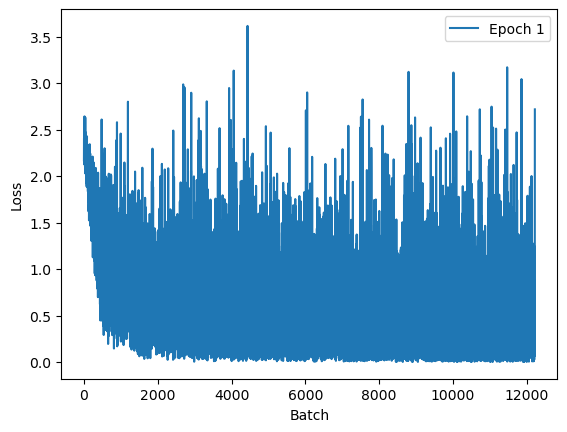

In [ ]:
import matplotlib.pyplot as plt

print("Graph of the loss at every epoch!")
plt.plot(every_epoch_loss[0], label='Epoch 1')
# plt.plot(every_epoch_loss[1], label='Epoch 2')
# plt.plot(every_epoch_loss[2], label='Epoch 3')
# plt.plot(every_epoch_loss[3], label='Epoch 4')
# plt.plot(every_epoch_loss[4], label='Epoch 5')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()